In [1]:
from IMP_CW_env import MESCEnv
import numpy as np 
from scipy.optimize import minimize, basinhopping

from HeuristicPolicy_file import HeuristicPolicy, Optimizer
from utils import plot_reward_distribution

import matplotlib.pyplot as plt
%matplotlib inline

# **Training environment definition**

In [2]:
n_retailers = 2
n_DCs = 1
n_suppliers = 1
supply_chain_structure = [[n_retailers] , [n_DCs], n_suppliers]

# **Policy optimization**
### Instantiate objects

In [3]:
env_train = MESCEnv(supply_chain_structure)
sSpolicy = HeuristicPolicy()

### **Run optimization**

#### **Option A**: use algorithms implemented in scipy.minimize

In [5]:
from scipy.optimize import Bounds
bounds = Bounds(np.zeros(6), [env_train.retailers[0].order_quantity_limit, # bounds for s_r1
                              env_train.retailers[0].order_quantity_limit, # bounds for S_r1
                              env_train.retailers[1].order_quantity_limit, # bounds for s_r2
                              env_train.retailers[1].order_quantity_limit, # bounds for S_r2
                              env_train.DCs[0].order_quantity_limit, # bounds for s_DC
                              env_train.DCs[0].order_quantity_limit]) # bounds for S_DC

In [9]:
optimizer = Optimizer(sSpolicy.objective_fcn, env_train)
options = None
results = sSpolicy.optimize_policy(env_train, optimizer.calculate_reward, method = 'Powell', bounds=bounds, callback = optimizer.callback, options = options)

In [10]:
results

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -169273.0
       x: [ 2.562e+01  2.995e+01  1.843e+01  3.671e+01  2.603e+01
            1.000e+02]
     nit: 3
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 9.593e+00  4.551e+00 ...  4.860e+01  1.352e-14]]
    nfev: 678

Get solution

In [11]:
optimizer.get_best_solution()
optimal_policy_sS = np.clip(np.floor(optimizer.best_x),a_min=0.,a_max=None).astype(int)

In [12]:
print(f'Converged: {results.success}')
print(f'Number of iterations: {optimizer.iter} \nBest objective function value: {optimizer.best_f:.2f}\nMaximum reward: {-1*optimizer.best_f:.2f}\nOptimal (s,S) policy: {optimal_policy_sS}')

Converged: True
Number of iterations: 3 
Best objective function value: -214387.50
Maximum reward: 214387.50
Optimal (s,S) policy: [ 18  30  15  19  21 152]


Visualize reward evolution

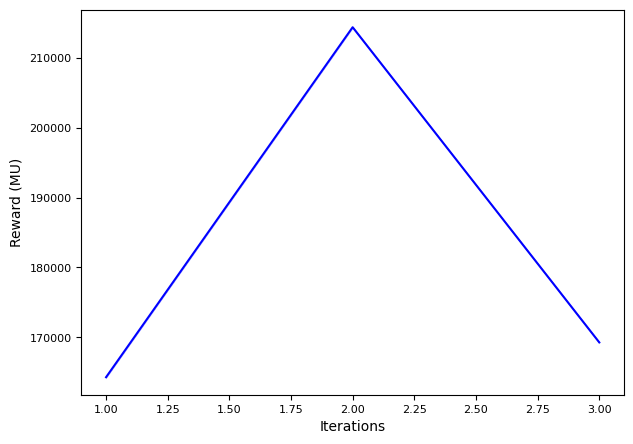

In [13]:
optimizer.plot_learning_curve()

#### **Option B:** use Bayesian Optimization

In [ ]:
from bayes_opt import BayesianOptimization

pbounds = {'s_r1': (0, 90), 'S_r1': (0, 90), 's_r2': (0, 90), 'S_r2': (0, 90), 's_DC': (0,210), 'S_DC': (0, 210)}
def objective_function_bayes(**kwargs):
    policy_param = np.array(list(kwargs.values()))
    return -1*sSpolicy.reward_fcn(policy_param, sSpolicy.policy_fcn, env_train)

optimizer = BayesianOptimization(f = objective_function_bayes, 
                                    pbounds = pbounds,
                                    random_state = 0,
                                    verbose = 0)
optimizer.maximize(init_points = 10, n_iter = 50)
optimal_policy_sS = np.array(list(optimizer.max['params'].values()))

In [ ]:
optimal_policy_sS

# **(s,S) Policy evaluation**

Note that here the policy is tested in the same environment where it was trained.

### Test dataset of demands
It will contain 100 samples for testing, each with 52 weeks.

In [14]:
test_demand_dataset = []
env_train.seed = 42
for _ in range(0,100):
    demands_episode, _ = env_train.sample_demands_episode()
    test_demand_dataset.append(demands_episode)

### Policy evaluation
Set the optimal policy parameters before running the evaluation.

In [15]:
sSpolicy.policy_param = optimal_policy_sS

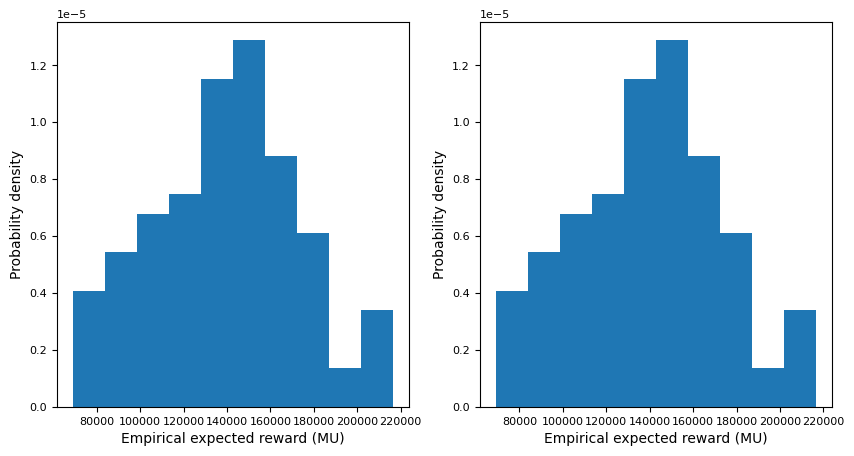

In [16]:
reward_list = sSpolicy.evaluate_policy(env_train, test_demand_dataset)
plot_reward_distribution(np.vstack([reward_list,reward_list]).T)